#### Much of this code is adapted from Professor David Stewart's (University of Iowa Dept. of Mathematics) base code

In [1]:
using LinearAlgebra
using Plots

## Optimal Fishing Effort

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u \\ \delta m + \beta f u \end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1$


#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [276]:
function F(t::Float64, xv::Vector{Float64}, u::Float64, params::Dict{String,Real}, verbose=0)
    alpha = get(params, "alpha", 0.1)
    delta = get(params, "delta", 0.05)
    beta = get(params, "beta", 1.0)
    f_max = get(params, "f_max", 1.0)
    f, m = xv 
    dfdt = alpha * f * (f_max - f) - beta * f * u
    dmdt = delta * m + beta * f * u
    func = [dfdt, dmdt]
    return func
end

function g(xv,verbose=0)
    return xv[2]
end

function dg(xv::Vector{Float64}, verbose=0) 
    return [0.0, -1.0]
end

dg (generic function with 4 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{u}$
$\quad$ $\nabla_{u} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} -f \\ f \end{bmatrix}$

In [277]:
function dFdu(xvect::Vector{Float64},u::Float64,params::Dict{String,Real},verbose=0)
    f = xv[1]
    beta = get(params, "beta", 1.0)
    grad = [-beta * f, beta * f]
    return reshape(grad,2,1)
end

dFdu (generic function with 2 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{x}$
$\quad$ $\nabla_{x} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} \alpha -2 \alpha f - u  && 0  \\ u  && \delta \end{bmatrix}$

In [278]:
function dFdx(t::Float64, xv::Vector{Float64}, u::Float64, params::Dict{String,Real}, verbose=0)
    f = xv[1]
    alpha = get(params, "alpha", 1.0)
    beta = get(params, "beta", 1.0)
    delta = get(params, "delta", 1.0)
    jacobian = [    -alpha * (1 - 2*f) + beta * u     beta * f     ;  
                              beta * u                 delta      ]
    return jacobian
end

dFdx (generic function with 2 methods)

#### Discretization via Euler's Method
$\quad$ $\textbf{x}_{k+1} = \textbf{x} + h\textbf{F}(\textbf{x}_{k},\textbf{u}_{k})$

This allows us to find $\textbf{x}(T)$ via a forward pass

In [280]:
function forwardstep(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,params::Dict{String,Real},verbose=0)
    N = size(u,2) # number of cols of u
    n = length(xv)
    xs = zeros(eltype(xv),n,N+1)
    xs[:,1] = xv
    h = get(params, "h", 0.1)
    for i = 0:N-1
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1][1],params)
    end
    return xs
end

forwardstep (generic function with 2 methods)

#### Lagrange Multiplier Equations
$\quad$ $\lambda_{k-1} = \lambda_{k} + h\nabla_{x} \textbf{F}(\textbf{x}_k, \textbf{u}_k)^T \lambda$

Moving backwards from the last $\lambda$ fills in the rest of the $\lambda$'s via a backward pass

In [281]:
# filling in the lagrange multipliers 
function adjointstep(λend::Vector{Float64},t0::Float64,xv::Matrix{Float64},u::Matrix{Float64},dFdx::Function,params::Dict{String,Real},verbose=0)
    N = size(u,2)
    n = length(λend)
    λs = zeros(eltype(λend),n,N)
    λs[:,N] = λend
    h = get(params, "h", 0.1)
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xv[:,i+1],u[:,i+1][1],params)'*λs[:,i+2]
    end
    λs
end


adjointstep (generic function with 2 methods)

#### Objective function
$\quad$ $g(\textbf{x}_N)=G(\textbf{u}_{0}, \textbf{u}_{1}, ... , \textbf{u}_{N-1})$

where $g(\textbf{x}_k)$ is the output at each step $k$

In [282]:
function G_init(x0,t0,u,h,F::Function,g::Function)
    xs = forwardstep(x0,t0,F,u,h)
    g(xs[:,end])
end

function dG_init(x0,t0,u,h,F::Function,dFdx::Function,dFdu::Function,dg::Function)
    xs = forwardstep(x0,t0,F,u,h)
    λend = dg(xs[:,end])
    λs = adjointstep(λend,t0,dFdx,xs,u,h)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:,i+1] = h*dFdu(t0+i*h,xs[:,i+1],u[:,i+1])'*λs[:,i+1]
    end
    dGval
end

dG_init (generic function with 1 method)

In [264]:
function G(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,g::Function,params::Dict{String,Real},verbose=0)
    xs = forwardstep(t0,xv,u,F,params)
    return g(xs[:,end])
end

G (generic function with 4 methods)

#### Gradient of objective function with respect to $\textbf{u}$
$\quad$ $\nabla_{u_{k}} g(\textbf{x}_{N}) = h\nabla_{u}\textbf{F}(\textbf{x}_{k}, \textbf{u}_{k})^T \lambda_{k}$

In [283]:
function dG(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,dg::Function,params,verbose=0)
    h = get(params, "h", 0.1)
    xs = forwardstep(t0,xv,u,F,params)
    λend = dg(xv[:,end])
    λs = adjointstep(λend,t0,xs,u,dFdx,params)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:, i+1] = h*dFdu(xs[:, i+1],u[i+1][1],params)'*λs[:, i+1]
    end
    dGval
end

dG (generic function with 4 methods)

#### Projection of controls onto $\space \mathcal{U}$
$\quad$ Search direction: $\textbf{d}=[(\textbf{d}_{0})^T, (\textbf{d}_{2})^T, ... , (\textbf{d}_{N-1})^T]^T$\
$\quad$ New control: $\textbf{u}^{+}(\alpha) = Proj_{\mathcal{U}}(\textbf{u}+\alpha \textbf{d})$, $\space$ $\mathcal{U}$ convex

This is to incorporate the constraints $\textbf{u}_{k} \in U \space \forall k$

In [284]:
function proj_u(u,a,b)
    clamp.(u, a, b)
end

proj_u (generic function with 3 methods)

#### Optimal Control Algorithm
Performs gradient descent in conjunction with backtracking line search on the iterates of $\textbf{u}$

In [285]:
function optcontrol(t0::Float64,x0::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,g::Function,dg::Function,ulist=nothing,trace=0)
    println("begin optimization")
    Gval = G(t0,x0,u,F,g,params,1)
    Gvalold = Gval
    dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,1)
    firsttime = true
    iter = 0
    c1 = get(params, "c1", 0.01)
    s0 = get(params, "s0", 1.0)
    h = get(params, "h", 0.1)
    maxiter = get(params, "maxiter", 10000)
    eps = get(params, "eps", 0.4)
    if ulist != nothing
        push!(ulist,u)
    end
    count = 0
    println("==========================")
    println("Initial Values")
    println("--------------------------")
    println("Gval: ", Gval)
    println("Gvalold: ", Gvalold)
    # println("dGval: ", dGval)
    # println("u: ", u)
    while ( firsttime || (Gvalold - Gval > eps) ) && (iter < maxiter)
        println("==========================")
        println("Iteration ", iter+1)
        println("--------------------------")
        println("Gvalold: ", Gvalold)
        Gvalold = Gval
        s = s0
        u_new_non_projected = u-s*dGval
        # println("u_nonproj: ", u_new_non_projected)
        # unew = proj_u(u-s*dGval,0.0,0.5) # projected gradient descent
        unew = u_new_non_projected
        Gval = G(t0,x0,unew,F,g,params)
        count_linesearch=0
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-6*s0
            s = s / 2
            unew = proj_u(u-s*dGval,0.0,0.5)
            Gval = G(t0,x0,unew,F,g,params,1)
            count_linesearch += 1
        end
        u = unew
        firsttime = false
        dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,0)

        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
        if iter < 5
            println("Line search steps: ", count_linesearch)
            println("Gval: ", Gval)
            println("dGval: ", dGval)
            # println("u: ", u)
        end
        count += 1
    end
    (u,iter)
end

optcontrol (generic function with 10 methods)

#### Parameters

In [286]:
using LinearAlgebra
xv  = [2.1; 1.1]
t = 0.0; 
N = 200
u = -ones(1,N)
du = 1e-3*[0.7]
T = 20 

params = Dict(
    "alpha"=>0.5,
    "delta"=>0.5,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>10_000
)

Dict{String, Real} with 9 entries:
  "eps"     => 0.01
  "c1"      => 0.05
  "f_max"   => 1.0
  "maxiter" => 10000
  "alpha"   => 0.5
  "s0"      => 1.0
  "h"       => 0.1
  "delta"   => 0.5
  "beta"    => 1.0

In [287]:
xs = forwardstep(t,xv,u,F,params,0)

2×201 Matrix{Float64}:
 2.1  2.1945  2.28288  2.36474   2.43985   …       3.0       3.0       3.0
 1.1  0.945   0.7728   0.583152  0.375835     -68606.2  -72036.8  -75638.9

In [288]:
λend = dg(xs[:,end])

2-element Vector{Float64}:
  0.0
 -1.0

In [289]:
λs = adjointstep(λend,t,xs,u,dFdx,params)

2×200 Matrix{Float64}:
 -6.92087e8  -6.40928e8  -5.76723e8  …   0.36025   0.22     0.1    0.0
 -1.21194e6   1.27031e8   2.41517e8     -1.06013  -1.0725  -1.05  -1.0

In [290]:
ulist = []
u = fill(0.5, 1,N)
opt_u,iters = optcontrol(0.0,xv,u,F,dFdx,dFdu,g,dg,ulist,0)

begin optimization
Initial Values
--------------------------
Gval: 35297.653935037786
Gvalold: 35297.653935037786
Iteration 1
--------------------------
Gvalold: 35297.653935037786
Line search steps: 1
Gval: 35297.653935037786
dGval: [-0.21000000003867456 -0.20999999995714919 -0.210000000045092 -0.20999999999458893 -0.20999999998455385 -0.21000000000310398 -0.21000000001980662 -0.20999999999380076 -0.2099999999983449 -0.20999999999496088 -0.20999999999408053 -0.20999999999566918 -0.2100000000049388 -0.21000000000266011 -0.21000000000220448 -0.21000000000006647 -0.2099999999968176 -0.2099999999941957 -0.21000000000121594 -0.2100000000009925 -0.21000000000050553 -0.2100000000000422 -0.20999999999727087 -0.21000000000266625 -0.21000000000080085 -0.21000000000069496 -0.20999999999987315 -0.2099999999987704 -0.20999999999971375 -0.2099999999997919 -0.20999999999958596 -0.21000000000033198 -0.2099999999994827 -0.20999999999929309 -0.20999999999961708 -0.20999999999972663 -0.20999999999940303

([0.5 0.5 … 0.5 0.5], 1)

In [291]:
opt_u

1×200 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5  0.5  0.5

In [292]:
xsopt = forwardstep(t,xv,opt_u,F,params)

2×201 Matrix{Float64}:
 2.1  1.8795  1.70287  1.55788  1.43653  …      0.0944825      0.0940362
 1.1  1.26    1.41698  1.57297  1.72951     33616.8        35297.7

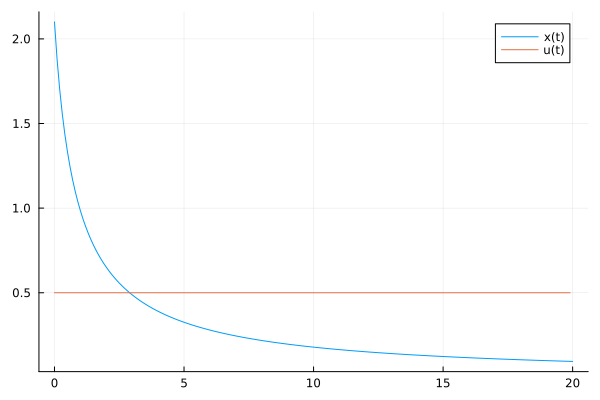

In [293]:
using Plots
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

#### Initial Parameters #1:
$\quad$ $T = 20\space years, \alpha = 0.1/year, \delta = 0.05/year, u_{max}=0.5, N=200, h=0.1$

## Optimal Fishing Effort - Addition of Predator

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u - \gamma f s\\ \gamma f s - \rho s \\ \delta m + \beta f u\end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1, \rho = 1, \alpha = 0.1, \gamma = 5$
#### So,
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(1-f)-f u \\ \delta m + f u \end{bmatrix}, x(0)=x_{0}, \textbf{u}(t)\in U  \space \forall t$

#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ -1 \end{bmatrix}$

In [231]:
function F_pred(t, x, u, alpha, delta, verbose=0)
    f, s, m = x
    dfdt = alpha * f * (1 - f) - f* u[1] - 5 * f * s
    dsdt = 5 * f * s - s
    dmdt = delta * m + u[1] * f

    if verbose == 1
        println("================================")
        println("[F] f: ", dfdt)
        println("[F] m: ", dfdt)
        println("[F] dfdf: ", dfdt)
        println("[F] dmdt: ", dfdt)
    end

    return [dfdt, dmdt]
end

function g(xv,verbose=0)
    if verbose == 1
        println("[g] g: ", -xv[2])
    end
    return -xv[2]
end

function dg(xv, verbose=0) 
    if verbose == 1
        println("[dg] dg: ", [0.0, 0.0, -1.0])
    end
    return [0.0, -1.0]
end

function dFdu_pred(t, xvect,u,alpha,delta,verbose=0)
    if verbose==1
        println("================================")
        println("[dFdu]: ",reshape([-xvect[1] ; xvect[1]],2,1))
    end
    return reshape([-xvect[1] ; xvect[1]],2,1)
end

function dFdx_pred(t, xv, u, alpha, delta,verbose=0)
    if verbose == 1
        println("================================")
        println("dFdx: ", [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta])
    end
    return [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta]
end

dFdx_pred (generic function with 2 methods)

In [232]:
using LinearAlgebra
xv  = [2.1; 1.1; 1.2]
dxv = 1e-3*[1.2; -0.7; 0.5]
t = 0; u = [0.5]; du = 1e-3*[0.7]
T = 20
alpha = 1
delta = 1
@show (F_pred(t,xv+dxv,u,alpha,delta)-F_pred(t,xv-dxv,u,alpha,delta)-2dFdx_pred(t,xv,u,alpha,delta)*dxv)/norm(dxv)
@show (F_pred(t,xv,u+du,alpha,delta,1)-F_pred(t,xv,u-du,alpha,delta,1)-2*dFdu_pred(t,xv,u,alpha,delta,1)*du)/norm(du)
@show (g_pred(xv+dxv,1)-g_pred|(xv-dxv,1)-2*dot(dg_pred(xv),dxv))/norm(dxv)

LoadError: cannot assign a value to imported variable Plots.alpha from module Main